In [1]:
from scipy.io import arff
from io import StringIO
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import math
from scipy import stats
import keras
from keras import backend as K
import pandas as pd
import neupy
from neupy import init, layers, algorithms
import sklearn
from sklearn import metrics,model_selection


Using TensorFlow backend.
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
p = { "attr_count": 11
}
file_content = ""
with open("pretreatmented.arff") as file:
    file_content = StringIO(file.read())
dataset, meta = arff.loadarff(file_content)

In [3]:
data = [[] for i in range(0, p["attr_count"])]
for i in range(0, p["attr_count"]):
    data[i] = dataset[i+1]

In [4]:
train_params = {
    "inputs": 10,
    "outputs": 1,
    "hidden": [25, 15, 10],
    "activations":["tanh", "tanh", "tanh", "tanh"],
    "batch": 50,
    "initializer": keras.initializers.glorot_normal(0),
    "initializer_neupy": neupy.init.XavierNormal(seed=0),
    "epochs": 200
}

In [5]:
attributes = [] # элемент = строка признаков
results = []
for vector in dataset:
    line = []
    for i in range(0, len(vector)):
        if i == len(vector) - 1:
            results.append(float(vector[i]))
            continue
        line.append(float(vector[i]))
    attributes.append(np.array(line))
attributes = np.array(attributes)
results = np.array(results)

In [6]:
values_dict = {
    'train': [1, 2, 3, 6, 8, 9],
    'valid': [0, 4, 7],
    'test' : [5]
}
v_train = { "x":[], "y":[] }
v_valid = { "x":[], "y":[] }
v_test = { "x":[], "y":[] }
train_attrs = attributes
for i in range(0, len(train_attrs)):
    if (i % 10) in values_dict['train']:
        v_train["x"].append(train_attrs[i])
        v_train["y"].append(results[i])
    elif (i % 10) in values_dict['valid']:
        v_valid["x"].append(train_attrs[i])
        v_valid["y"].append(results[i])
    else:
        v_test["x"].append(train_attrs[i])
        v_test["y"].append(results[i])
v_train["x"] = np.array(v_train["x"])
v_train["y"] = np.array(v_train["y"])
v_valid["x"] = np.array(v_valid["x"])
v_valid["y"] = np.array(v_valid["y"])
v_test["x"] = np.array(v_test["x"])
v_test["y"] = np.array(v_test["y"])

In [7]:
def keras_create_model():
    return keras.models.Sequential(
        [
            keras.layers.Dense(
                train_params["hidden"][0], 
                input_dim = train_params["inputs"], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][0]
            ),
            keras.layers.Dense(
                train_params["hidden"][1], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][1]
            ),
            keras.layers.Dense(
                train_params["hidden"][2], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][2]
            ),
            keras.layers.Dense(
                train_params["outputs"], 
                kernel_initializer = train_params["initializer"],
                bias_initializer = train_params["initializer"],
                activation = train_params["activations"][3]
            )
        ]
    )

In [8]:
class KerasErrorCollectorCallback(keras.callbacks.Callback):
    def __init__(self):
        self.errors = {
            "train":[],
            "valid":[],
            "test":[]
        }
        
    def on_epoch_end(self, epoch, logs={}):        
        train_error = self.model.evaluate(v_train["x"], v_train["y"], verbose = 0, batch_size = len(v_train["x"]))
        valid_error = self.model.evaluate(v_valid["x"], v_valid["y"], verbose = 0, batch_size = len(v_valid["x"]))
        test_error = self.model.evaluate(v_test["x"], v_test["y"], verbose = 0, batch_size = len(v_test["x"]))
        self.errors["train"].append(train_error)
        self.errors["valid"].append(valid_error)
        self.errors["test"].append(test_error)
    
class KerasEarlyStoppingCallback(keras.callbacks.Callback):
    def __init__(self, waiting_epochs, delta):
        self.waiting_epochs = waiting_epochs
        self.delta = delta
        self.best_epoch = 0
        self.min_error = 10**3
        self.waited_epochs = 0
        self.was_early_stopping = False
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        if self.was_early_stopping:
            return
        valid_error = self.model.evaluate(v_valid["x"], v_valid["y"], verbose = 0, batch_size = len(v_valid["x"]))
        if valid_error < self.min_error:
            self.best_epoch = self.epoch
            self.min_error = valid_error 
            if self.waited_epochs > 0:
                self.waited_epochs -= 2
        else:
            if self.waited_epochs > self.waiting_epochs:
                self.was_early_stopping = True
                return
            if valid_error - self.min_error > self.delta:
                self.waited_epochs += 1
            self.waited_epochs += 1
            
from functools import reduce
class KerasLearningRateCallback(keras.callbacks.Callback):
    def __init__(self, neurons, x, y, b_size):
        self.neurons = neurons #Словарь вида {номер_слоя:(i, j)....}, (i, j) - номер веса в матрице
        self.x = x
        self.y = y
        self.b_size = b_size
        
    def on_train_begin(self, logs={}):
        weights = self.model.trainable_weights 
        current_lr = np.array(self.model.optimizer.lr)#(self.model.total_loss, weights)
        input_tensors = [self.model.inputs[0], # input data
                 self.model.sample_weights[0], # how much to weight each sample by
                 self.model.targets[0], # labels
                 K.learning_phase(), # train or test mode
        ]
        self.get_current_lr = K.function(inputs=input_tensors, outputs= current_lr)
        
        self.max_lr = []
        self.min_lr = []
        self.mean_lr = []
        self.neuron_lr = []
        for i in self.neurons:
            self.neuron_lr.append([])

    def on_epoch_begin(self, batch, logs={}):
        start = batch*self.b_size  #начало батча
        end = (batch+1)*self.b_size if batch*self.b_size < len(self.x) else len(self.x)  #конец батча
        inputs = [self.x[start:end], # X
          [1], # sample weights
          self.y[start:end], # y
          0 # learning phase in TEST mode
        ]
        current_lr = self.get_current_lr(inputs) # список матриц, содержащих lr для каждого слоя
        max_lr = []
        min_lr=[]
        sum_lr = []
        for layer, neuron in self.neurons.items():
            bias, weights = current_lr[2*(layer-1):2*layer][1].reshape(1, -1), current_lr[2*(layer-1):2*layer][0]
            current_lr_layer = np.concatenate([bias, weights], axis=0)
            self.neuron_lr[layer-1].append(current_lr_layer[neuron])
            max_lr.append(np.max(current_lr_layer))
            min_lr.append(np.min(current_lr_layer))
            sum_lr.append(np.sum(current_lr_layer))
        self.max_lr.append(max(max_lr))
        self.min_lr.append(min(min_lr))
        self.mean_lr.append(reduce(lambda y, x: y+x, sum_lr)/self.model.count_params())

In [9]:
def keras_fit_model(optimizer, lr = False):
    error_collector = KerasErrorCollectorCallback()
    early_stopping = KerasEarlyStoppingCallback(waiting_epochs=30, delta=0.01)
    learning_rate = KerasLearningRateCallback(
        {1:(3, 5), 2:(4, 2), 3:(9, 2), 4:(2, 6)}, v_train["x"], v_train["y"], train_params["batch"]
    )
    callbacks = [error_collector, early_stopping]
    if lr:
        callbacks.append(learning_rate)
    model = keras_create_model()
    model.compile(
        loss = "binary_crossentropy", 
        optimizer = optimizer,
        metrics = []
    )
    history = model.fit(
        v_train["x"],
        v_train["y"],
        epochs = train_params["epochs"],
        verbose = 0,
        batch_size = train_params["batch"],
        callbacks = callbacks
    )
    return error_collector, early_stopping, learning_rate


In [10]:
def keras_train_and_get_info(optimizer, lr = False):
    error_collector, early_stopping, learning_rate = keras_fit_model(
        optimizer, lr
    )
    best_epoch = early_stopping.best_epoch
    info = [
        best_epoch,
        error_collector.errors["train"][best_epoch-1],
        error_collector.errors["test"][best_epoch-1]
    ]
    if lr:
        return info, error_collector, learning_rate
    return info, error_collector

In [11]:
def keras_show_tvt_values(error_collector):
    _, picture = plt.subplots(figsize=(25,10))
    _ = picture.plot(error_collector.errors["train"], lw=3, label="На обучающей")
    _ = picture.plot(error_collector.errors["valid"], lw=3, label="На валидационной")
    _ = picture.plot(error_collector.errors["test"], lw=3, label="На тестовой")
    _ = picture.legend()

In [12]:
def keras_show_learning_rates(lr_curve, title):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(lr_curve.max_lr)+1),lr_curve.max_lr, label='Max lr')
    plt.plot(range(1,len(lr_curve.min_lr)+1),lr_curve.min_lr,label='Min lr')
    plt.plot(range(1,len(lr_curve.mean_lr)+1),lr_curve.mean_lr,label='Mean lr')
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    for layer, neuron in lr_curve.neurons.items():
        plt.plot(range(1,len(lr_curve.neuron_lr[layer-1])+1),lr_curve.neuron_lr[layer-1], label='Layer {}, w[{},{}]'.format(layer, neuron[0],neuron[1]))
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.legend()
    plt.show()

In [13]:
def neupy_create_model():
    return neupy.layers.join(
        neupy.layers.Input(train_params["inputs"]),
        neupy.layers.Tanh(train_params["hidden"][0], weight=train_params["initializer_neupy"]),
        neupy.layers.Tanh(train_params["hidden"][1], weight=train_params["initializer_neupy"]),
        neupy.layers.Tanh(train_params["hidden"][2], weight=train_params["initializer_neupy"]),
        neupy.layers.Sigmoid(train_params["outputs"], weight=train_params["initializer_neupy"])
    )

In [14]:
flag_use_MSE = False
class NeupyErrorCollectorSignal(object):
    def __init__(self):
        self.errors = {
            "train":[],
            "valid":[],
            "test":[]
        }
        
    def epoch_end(self, optimizer):
        train_error = 0
        if flag_use_MSE:
            train_error = sklearn.metrics.mean_squared_error(v_train["y"], optimizer.predict(v_train["x"]).flatten())
        else:
            train_error = sklearn.metrics.log_loss(v_train["y"], optimizer.predict(v_train["x"]).flatten())
        self.errors["train"].append(train_error)
        
        valid_error = 0
        if flag_use_MSE:
            valid_error = sklearn.metrics.mean_squared_error(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        else:
            valid_error = sklearn.metrics.log_loss(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        self.errors["valid"].append(valid_error)
        
        test_error = 0
        if flag_use_MSE:
            test_error = sklearn.metrics.mean_squared_error(v_test["y"], optimizer.predict(v_test["x"]).flatten())
        else:
            test_error = sklearn.metrics.log_loss(v_test["y"], optimizer.predict(v_test["x"]).flatten())
        self.errors["test"].append(test_error)

class NeupyEarlyStoppingSignal(object):
    def __init__(self, waiting_epochs, delta):
        self.waiting_epochs = waiting_epochs
        self.delta = delta
        self.best_epoch = 0
        self.min_error = 10**3
        self.waited_epochs = 0
        self.was_early_stopping = False
        self.epoch = 0
    
    def epoch_end(self, optimizer):
        self.epoch += 1
        if self.was_early_stopping:
            return
        if flag_use_MSE:
            valid_error = sklearn.metrics.mean_squared_error(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        else:
            valid_error = sklearn.metrics.log_loss(v_valid["y"], optimizer.predict(v_valid["x"]).flatten())
        if valid_error < self.min_error:
            self.best_epoch = self.epoch
            self.min_error = valid_error
            if self.waited_epochs > 0:
                self.waited_epochs -= 2
        else:
            if self.waited_epochs > self.waiting_epochs:
                self.was_early_stopping = True
                return
            if valid_error - self.min_error > self.delta:
                self.waited_epochs += 1
            self.waited_epochs += 1
            
sess = neupy.utils.tensorflow_session()
class Increment_Curve(object):
    def __init__(self, neurons_numbers):
        self.neurons = neurons_numbers
        
    def train_start(self, optimizer, **kwargs):
        self.max_increment = []
        self.min_increment = []
        self.mean_increment = []
        self.neuron_increment = []
        self.prev_weights = []
        for i in self.neurons:
            self.neuron_increment.append([])
        
    def epoch_end(self, optimizer):
        epoch_increment = np.array([])
        if len(self.prev_weights) > 0:
            for layer, neuron in self.neurons.items():
                weight = sess.run(optimizer.network.layers[layer].weight)
                bias = sess.run(optimizer.network.layers[layer].bias)
                current_weights = np.concatenate([bias.reshape(1, -1), weight], axis=0)
                increment = current_weights - self.prev_weights[layer-1]
                self.neuron_increment[layer-1].append(increment[neuron])
                epoch_increment = np.append(epoch_increment, increment)
                self.prev_weights[layer-1] = current_weights
            self.max_increment.append(epoch_increment.max())
            self.min_increment.append(epoch_increment.min())
            self.mean_increment.append(epoch_increment.mean())
        else:
            for layer, neuron in self.neurons.items():
                weight = K.get_value(optimizer.network.layers[layer].weight)
                bias = K.get_value(optimizer.network.layers[layer].bias)
                current_weights = np.concatenate([bias.reshape(1, -1), weight], axis=0)
                self.prev_weights.append(current_weights) 

In [15]:
def neupy_train_and_get_info(optimizer_name, param = 0, inc = False):
    error_collector = NeupyErrorCollectorSignal()
    early_stopping = NeupyEarlyStoppingSignal(waiting_epochs=30, delta=0.01)
    incr = Increment_Curve({1:(3, 5), 2:(3, 9), 3:(10, 2), 4:(0, 0)})
    callbacks = [error_collector, early_stopping]
    if inc:
        callbacks.append(incr)
    model = neupy_create_model()
    optimizer = None
    if optimizer_name == "RMSProp":
        optimizer = neupy.algorithms.RMSProp(
            network = model, 
            loss = "binary_crossentropy", 
            momentum = param,
            batch_size = train_params["batch"],
            signals = callbacks
        )
    elif optimizer_name == "GD":
        optimizer = neupy.algorithms.GradientDescent(
            network = model, 
            loss = "binary_crossentropy", 
            step = param,
            batch_size = train_params["batch"],
            signals = callbacks
        )
    elif optimizer_name == "Fletcher-Reeeves":
        optimizer = neupy.algorithms.ConjugateGradient(
            network = model,
            loss = "binary_crossentropy",
            update_function = "fletcher_reeves",
            signals = callbacks
        )
    elif optimizer_name == "Polak-Ribiere":
        optimizer = neupy.algorithms.ConjugateGradient(
            network = model,
            loss = "binary_crossentropy",
            update_function = "polak_ribiere",
            signals = callbacks
        )
    elif optimizer_name == "RProp":
        optimizer = neupy.algorithms.RPROP(
            network = model,
            loss = "binary_crossentropy",
            verbose = True,
            signals = callbacks
        )
    elif optimizer_name == "LM":
        optimizer = neupy.algorithms.LevenbergMarquardt(
            network = model,
            signals = callbacks
        )
    elif optimizer_name == "BFGS":
        optimizer = neupy.algorithms.QuasiNewton(
            network = model,
            loss = "binary_crossentropy",
            update_function = "bfgs",
            signals = callbacks
        )
    elif optimizer_name == "SteepestGD":
        optimizer = SteepestGD(
            network = model,
            loss = "binary_crossentropy",
            signals = callbacks
        )
    optimizer.train(
        v_train["x"],
        v_train["y"],
        epochs = train_params["epochs"]
    )
    best_epoch = early_stopping.best_epoch
    info = [
        best_epoch,
        error_collector.errors["train"][best_epoch-1],
        error_collector.errors["test"][best_epoch-1]
    ]
    if inc:
        return info, error_collector, incr
    return info, error_collector

In [16]:
def neupy_show_tvt_values(error_collector):
    _, picture = plt.subplots(figsize=(25,10))
    _ = picture.plot(error_collector.errors["train"], lw=3, label="На обучающей")
    _ = picture.plot(error_collector.errors["valid"], lw=3, label="На валидационной")
    _ = picture.plot(error_collector.errors["test"], lw=3, label="На тестовой")
    _ = picture.legend()

In [17]:
def plot_increment(inc_curve, title):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(inc_curve.max_increment)+1),inc_curve.max_increment, label='Max increment')
    plt.plot(range(1,len(inc_curve.min_increment)+1),inc_curve.min_increment,label='Min increment')
    plt.plot(range(1,len(inc_curve.mean_increment)+1),inc_curve.mean_increment,label='Mean increment')
    
    plt.xlabel('epochs')
    plt.ylabel('increment')
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    for layer, neuron in inc_curve.neurons.items():
        plt.plot(range(1,len(inc_curve.neuron_increment[layer-1])+1),inc_curve.neuron_increment[layer-1], label='Layer {}, w[{},{}]'.format(layer, neuron[0],neuron[1]))
    plt.xlabel('batch')
    plt.ylabel('lr')
    fig.suptitle(title, fontsize="x-large")
    
    plt.grid(True)
    plt.legend()
    plt.show()

In [19]:
info_FR, error_collector_FR = neupy_train_and_get_info("Fletcher-Reeeves")

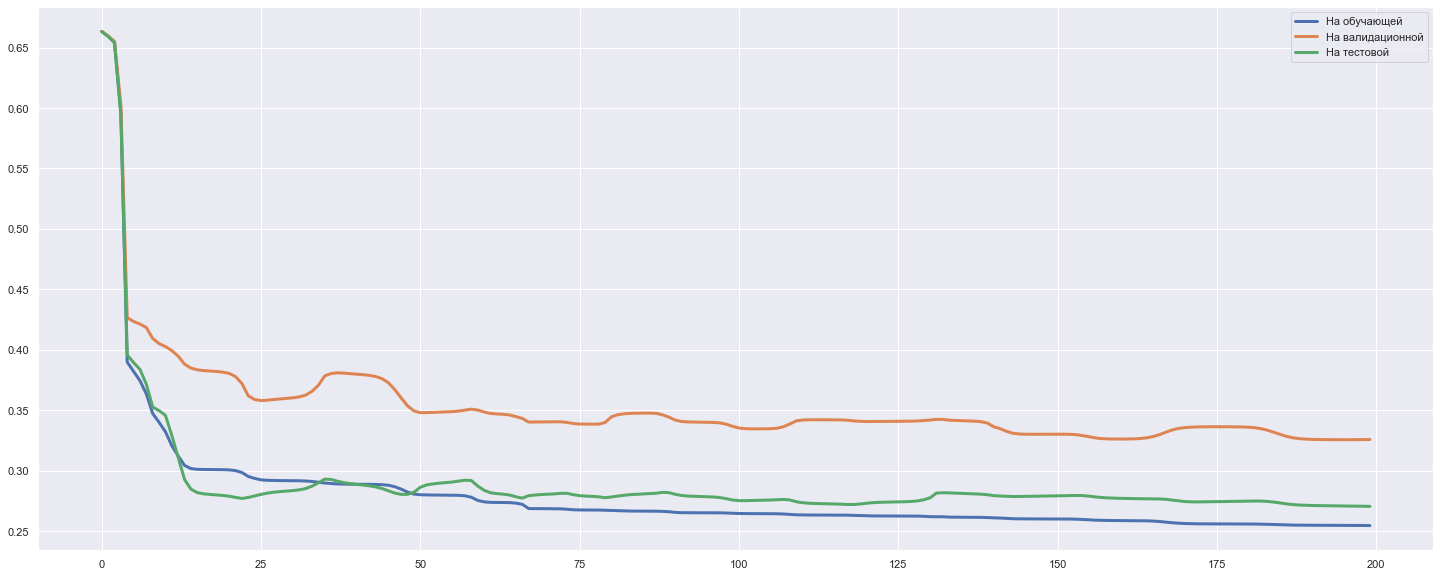

In [20]:
neupy_show_tvt_values(error_collector_FR)